In [1]:
import optuna
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

from sklearn import model_selection
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('ml_before.csv')

In [ ]:
# データの分割
X = df.drop(['日付け','終値'], axis=1) # 説明変数
y = df['終値'] # 目的変数
    
# 学習データとテストデータの分割
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

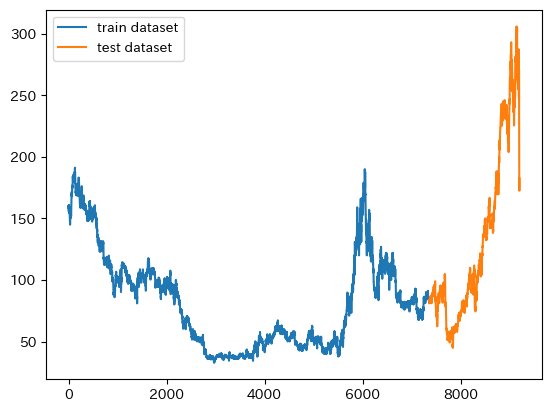

In [4]:
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="train dataset")
ax.plot(y_test.index, y_test.values, label="test dataset")
plt.legend()

In [5]:
seed = 42
# モデル作成
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
train_pred = model.predict(X_train.values)
test_pred = model.predict(X_test.values)
# 精度指標（テストデータ）
print('MAE:')
print(mean_absolute_error(y_test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(y_test, test_pred))

MAE:
13.895878576623687
MAPE:
0.057001529693082614


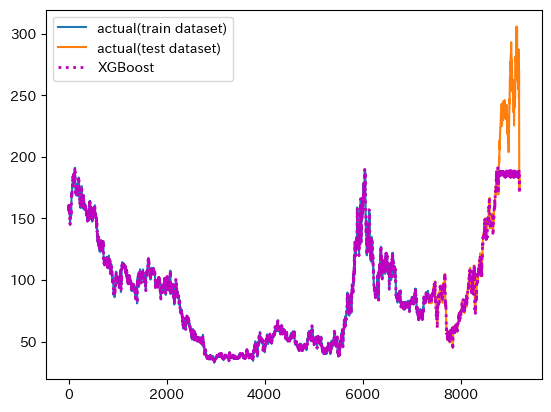

In [7]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m")
ax.plot(y_test.index, test_pred, label="XGBoost", linestyle="dotted", lw=2, color="m") 
plt.legend()

Optunaによるパラメータチューニング

In [ ]:
def objective(trial):
    # ハイパーパラメータの設定
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 0,
        'n_jobs': -1
    }
        
    model.set_params(**params)

    #クロスバリデーションの設定
    score = model_selection.cross_val_score(model,
                                            X_train,
                                            y_train,
                                            n_jobs=-1,
                                            cv=10,
                                            scoring = 'neg_mean_squared_error'
                                           )
    
    val = - score.mean()
    return val

In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-11-05 13:06:55,558] A new study created in memory with name: no-name-fbd65800-4fd3-4cf1-8a02-7a21600a0b5d
/var/folders/ny/dsc26swj73jgprpw8ck05ztw0000gn/T/ipykernel_5476/2293405285.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/var/folders/ny/dsc26swj73jgprpw8ck05ztw0000gn/T/ipykernel_5476/2293405285.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/ny/dsc26swj73jgprpw8ck05ztw0000gn/T/ipykernel_5476/2293405285.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

In [10]:
# 最適解の出力
print(f"The best parameters are : \n {study.best_params}")

The best parameters are : 
 {'n_estimators': 894, 'max_depth': 2, 'learning_rate': 0.029637656652482334, 'subsample': 0.9679885706695216, 'colsample_bytree': 0.9508217611430344, 'gamma': 0.00017561960422075542, 'reg_alpha': 7.241455669450666e-05, 'reg_lambda': 2.259043672430842e-05}


In [11]:
# 最適パラメータでモデル学習
model = XGBRegressor(**study.best_params)
model.fit(X_train.values, y_train.values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9508217611430344, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.00017561960422075542,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.029637656652482334,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=894, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# 予測
train_pred = model.predict(X_train.values)
test_pred = model.predict(X_test.values)
# 精度指標（テストデータ）
print('MAE:')
print(mean_absolute_error(y_test, test_pred))
print('MAPE:')
print(mean_absolute_percentage_error(y_test, test_pred))

MAE:
13.400356097949192
MAPE:
0.05489519973602772


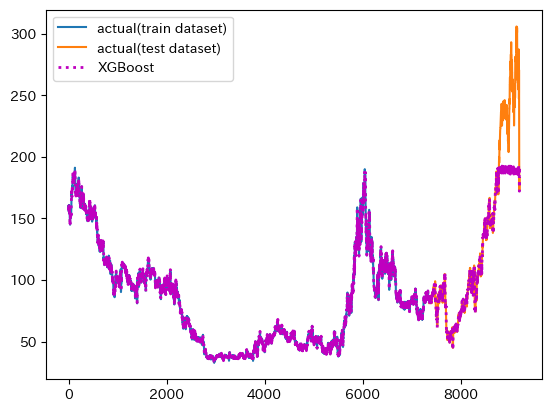

In [13]:
# グラフ化
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train.values, label="actual(train dataset)")
ax.plot(y_test.index, y_test.values, label="actual(test dataset)")
ax.plot(y_train.index, train_pred, linestyle="dotted", lw=2,color="m")
ax.plot(y_test.index, test_pred, label="XGBoost", linestyle="dotted", lw=2, color="m") 
plt.legend()